Tubeの場所と予測を保存

In [1]:
import ast
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [2]:
df = pd.read_csv('/data/df_train2.csv')
df_anot = pd.read_csv('/data/train_annotations.csv')
df_bifurcation = pd.read_csv('/data/additional/RANZCR_CLiP_tracheal_bifurcation.csv')
df_cvc = pd.read_csv('/data/additional/cvc_malposition_categories.csv')

In [4]:
df_cvc.label.value_counts()

CVC - Abnormal - Right Atrium    783
CVC - Abnormal - Other           428
Name: label, dtype: int64

In [5]:
df[df["CVC - Abnormal"] == 1]

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,fold,img_path,cv
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814,0,/data/train512/1.2.826.0.1.3680043.8.498.68286...,0
19,1.2.826.0.1.3680043.8.498.10129559062963528496...,0,0,1,0,0,0,1,1,0,0,0,9ebe3d714,2,/data/train512/1.2.826.0.1.3680043.8.498.10129...,2
21,1.2.826.0.1.3680043.8.498.43104496908194932746...,0,0,1,0,0,1,0,1,0,0,0,e43599771,1,/data/train512/1.2.826.0.1.3680043.8.498.43104...,1
41,1.2.826.0.1.3680043.8.498.94564462859946775522...,0,0,0,0,0,0,0,1,0,0,0,add388951,3,/data/train512/1.2.826.0.1.3680043.8.498.94564...,3
43,1.2.826.0.1.3680043.8.498.23522123195677570717...,0,0,0,0,0,0,0,1,0,0,0,20335f7d1,4,/data/train512/1.2.826.0.1.3680043.8.498.23522...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30059,1.2.826.0.1.3680043.8.498.25116746918324400178...,0,0,0,0,0,0,0,1,0,0,0,a76d2acc0,3,/data/train512/1.2.826.0.1.3680043.8.498.25116...,3
30066,1.2.826.0.1.3680043.8.498.22428607248263186250...,0,0,0,0,0,0,0,1,0,0,0,20d23851d,2,/data/train512/1.2.826.0.1.3680043.8.498.22428...,2
30068,1.2.826.0.1.3680043.8.498.98624384591890799789...,0,0,1,0,0,1,0,1,0,1,0,5733c2458,3,/data/train512/1.2.826.0.1.3680043.8.498.98624...,3
30076,1.2.826.0.1.3680043.8.498.59704742952729813362...,0,0,0,0,0,0,0,1,0,0,0,172c3c7ed,1,/data/train512/1.2.826.0.1.3680043.8.498.59704...,1


In [17]:
import math
def sigmoid(a):
    s = 1 / (1 + math.e**-a)
    return s

In [18]:
oof_800 = sigmoid(np.load('/workspace/output/exp024_test800_2/oof/oof.npy'))
oof_864 = sigmoid(np.load('/workspace/output/exp024_test864_2/oof/oof.npy'))
oof = (oof_800 + oof_864) / 2

In [19]:
df_oof = df.copy()
df_oof.loc[:, df.columns[1:12]] = oof
df_oof.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,fold,img_path,cv
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0.001345,0.003047,0.003735,0.016243,0.106178,0.009688,0.798720,0.176817,0.059686,0.062804,0.000457,ec89415d1,3,/data/train512/1.2.826.0.1.3680043.8.498.26697...,3
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0.001430,0.076165,0.936450,0.241422,0.055716,0.776671,0.066677,0.027979,0.091682,0.870807,0.003910,bf4c6da3c,3,/data/train512/1.2.826.0.1.3680043.8.498.46302...,3
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0.000007,0.000042,0.000059,0.000032,0.000043,0.000065,0.000050,0.014588,0.572776,0.412521,0.000046,3fc1c97e5,3,/data/train512/1.2.826.0.1.3680043.8.498.23819...,3
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0.000134,0.000346,0.001272,0.002425,0.001956,0.000898,0.000724,0.978339,0.024767,0.021996,0.000234,c31019814,0,/data/train512/1.2.826.0.1.3680043.8.498.68286...,0
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0.000015,0.000637,0.014400,0.000177,0.000206,0.000502,0.000376,0.000678,0.002632,0.998719,0.000002,207685cd1,0,/data/train512/1.2.826.0.1.3680043.8.498.10050...,0


In [20]:
cvc_cols = ["CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]

In [21]:
df["is_cvc"] = df[cvc_cols].max(1)

In [22]:
df["CVC - Abnormal"].value_counts()

0    26888
1     3195
Name: CVC - Abnormal, dtype: int64

In [23]:
df["CVC - Borderline"].value_counts()

0    21623
1     8460
Name: CVC - Borderline, dtype: int64

In [24]:
df["CVC - Normal"].value_counts()

1    21324
0     8759
Name: CVC - Normal, dtype: int64

CVCの先端を自分で見つけ出すことは可能かな？

必要なところだけをピックアップ

# 手動ラベリングとか

In [63]:
def plot_xray(StudyInstanceUID, label, data):
    """
    intubation as green
    bifurcation as red
    """
    pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
    Normal = pred["CVC - Normal"].values[0]
    Borderline = pred["CVC - Borderline"].values[0]
    Abnormal = pred["CVC - Abnormal"].values[0]
    
    
    img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
    intubation = ast.literal_eval(data)
#     intubation = ast.literal_eval(df_anot.loc[(df_anot.StudyInstanceUID==StudyInstanceUID) & (df_anot.label==label),'data'].values[0])
    for i in range(len(intubation)):
        img = cv2.circle(img, tuple(intubation[i]), 10, (0,255,0), 10)
        img = cv2.putText(img, str(i), (intubation[i][0]-10, intubation[i][1]-10), cv2.FONT_HERSHEY_PLAIN, fontScale=5, color=(255, 0, 0), thickness=2)
    img = cv2.circle(img, (img.shape[1]//2, img.shape[0]//2), 10, (0,0,255), 10)
    plt.figure(figsize=(12,12))
    plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
    plt.imshow(img)
    
def save_xray(StudyInstanceUID, label, data, patient_id, num):
    """
    intubation as green
    bifurcation as red
    """
    pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
    Normal = pred["CVC - Normal"].values[0]
    Borderline = pred["CVC - Borderline"].values[0]
    Abnormal = pred["CVC - Abnormal"].values[0]
    
    img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
#     intubation = ast.literal_eval(df_anot.loc[(df_anot.StudyInstanceUID==StudyInstanceUID) & (df_anot.label==label),'data'].values[0])
    intubation = ast.literal_eval(data)
    for i in range(len(intubation)):
        img = cv2.circle(img, tuple(intubation[i]), 10, (0,255,0), 10)
        img = cv2.putText(img, str(i), (intubation[i][0]-10, intubation[i][1]-10), cv2.FONT_HERSHEY_PLAIN, fontScale=5, color=(255, 0, 0), thickness=2)
    img = cv2.circle(img, (img.shape[1]//2, img.shape[0]//2), 10, (0,0,255), 10)
    ax = plt.figure(figsize=(12,12))
    plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
    plt.imshow(img)
    plt.savefig(f"/data/eda_plot/cvc_tube/{patient_id}_{StudyInstanceUID}_{label}_{num}.jpeg")
    plt.clf()
    plt.close()
    del ax
    gc.collect()

In [47]:
df_cvc = df[df.is_cvc == 1]

In [48]:
cvc_study_id = df_cvc.StudyInstanceUID.values

In [49]:
df_anot_cvc = df_anot[df_anot.label.isin(cvc_cols)]

In [50]:
# ind = i
# row = df_anot_cvc[df_anot_cvc.StudyInstanceUID == "1.2.826.0.1.3680043.8.498.56123128911983663680403594219494298539"]
# plot_xray(row.StudyInstanceUID, row.label)

In [51]:
df_anot_cvc

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
5,1.2.826.0.1.3680043.8.498.87704688663091069148...,CVC - Normal,"[[906, 604], [1103, 578], [1242, 607], [1459, ..."
...,...,...,...
17993,1.2.826.0.1.3680043.8.498.88885675487819792225...,CVC - Normal,"[[1384, 1098], [1480, 899], [1554, 774], [1630..."
17995,1.2.826.0.1.3680043.8.498.18590666552942008211...,CVC - Normal,"[[1250, 1105], [1247, 1031], [1248, 970], [126..."
17996,1.2.826.0.1.3680043.8.498.66774579023475418162...,CVC - Normal,"[[1379, 1402], [1389, 1233], [1386, 1137], [13..."
17997,1.2.826.0.1.3680043.8.498.18560506324214035535...,CVC - Normal,"[[1302, 1543], [1308, 1488], [1317, 1355], [13..."


In [52]:
df_anot_cvc.StudyInstanceUID.iloc[0]

'1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307'

In [53]:
df_anot_cvc.StudyInstanceUID.iloc[1]

'1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307'

In [54]:
df_anot_cvc.data.iloc[0]

'[[1487, 1279], [1477, 1168], [1472, 1052], [1464, 924], [1453, 827], [1443, 755], [1434, 640], [1404, 514], [1387, 497], [1360, 541], [1290, 617], [1228, 696], [1179, 776], [1116, 880], [1065, 963], [1031, 999]]'

In [55]:
df_anot_cvc.data.iloc[1]

'[[1328, 7], [1347, 101], [1383, 193], [1400, 267], [1411, 366], [1400, 428], [1387, 545], [1394, 640], [1400, 707], [1417, 783], [1432, 852], [1462, 953], [1457, 1006]]'

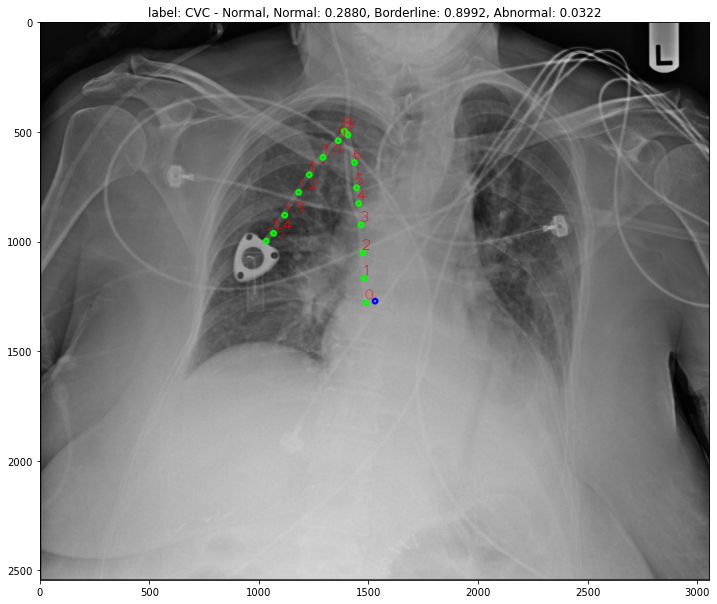

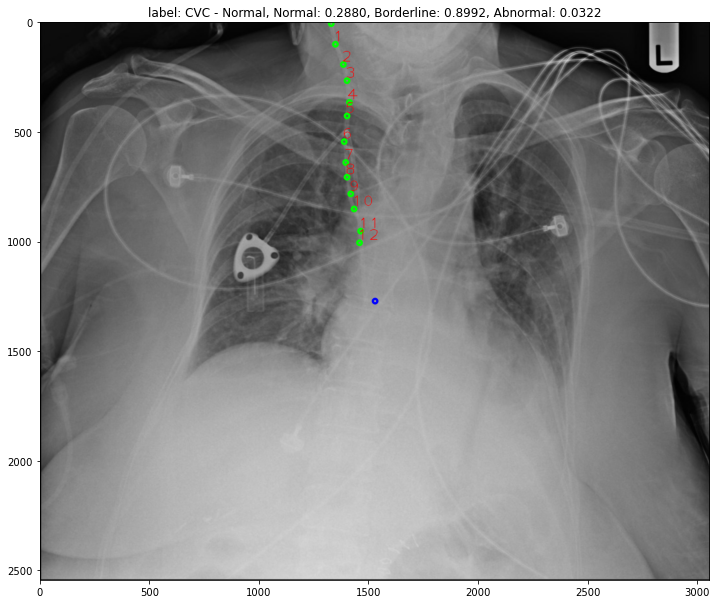

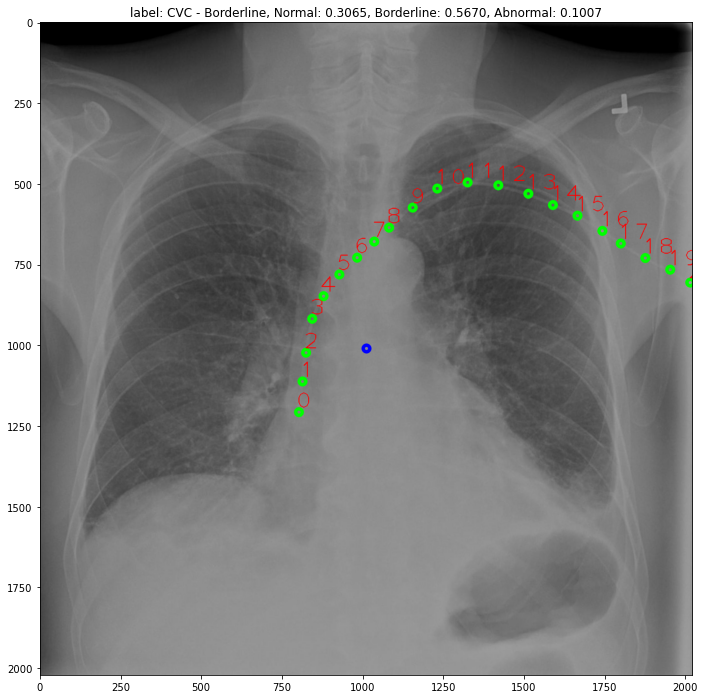

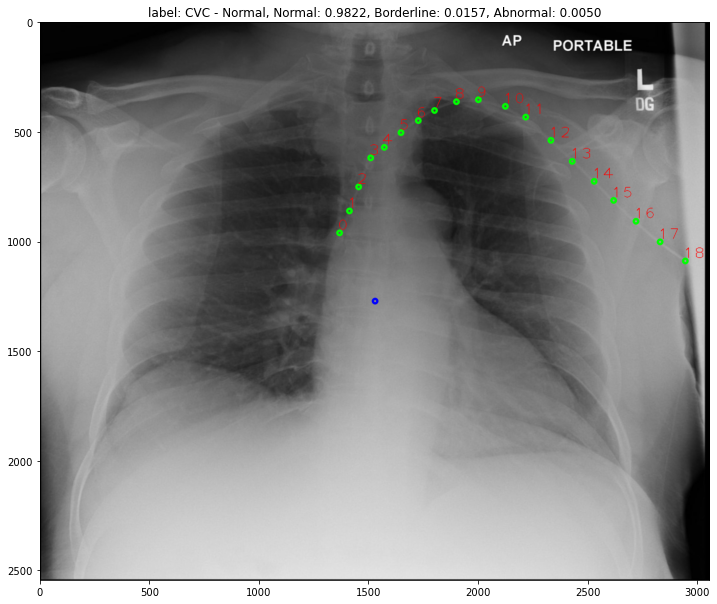

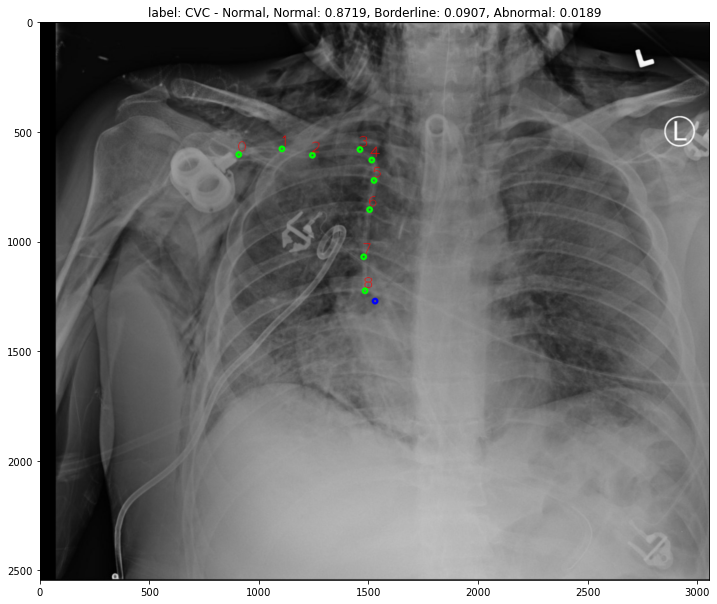

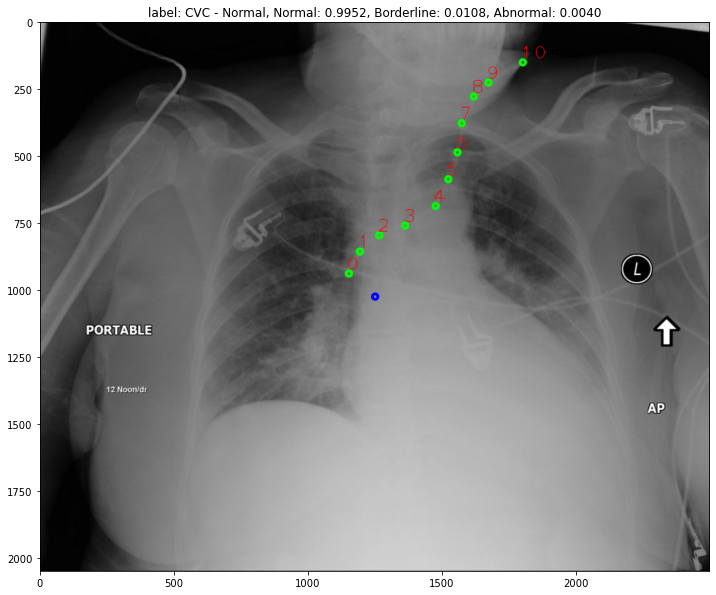

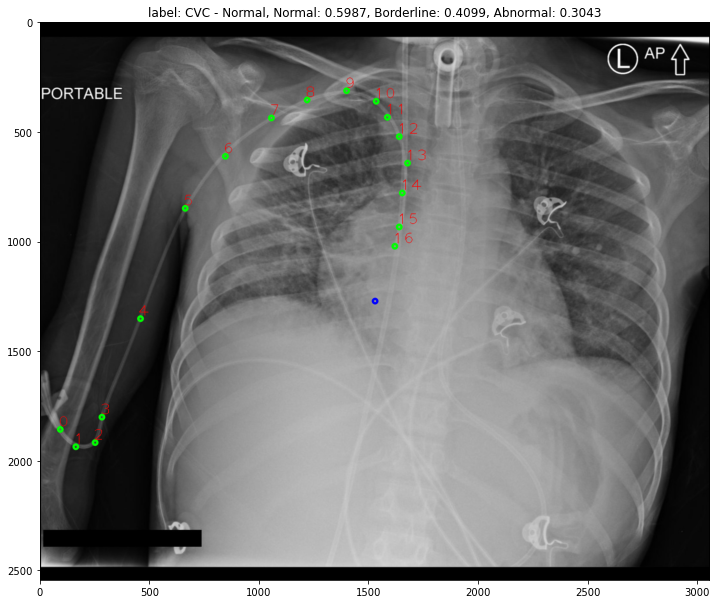

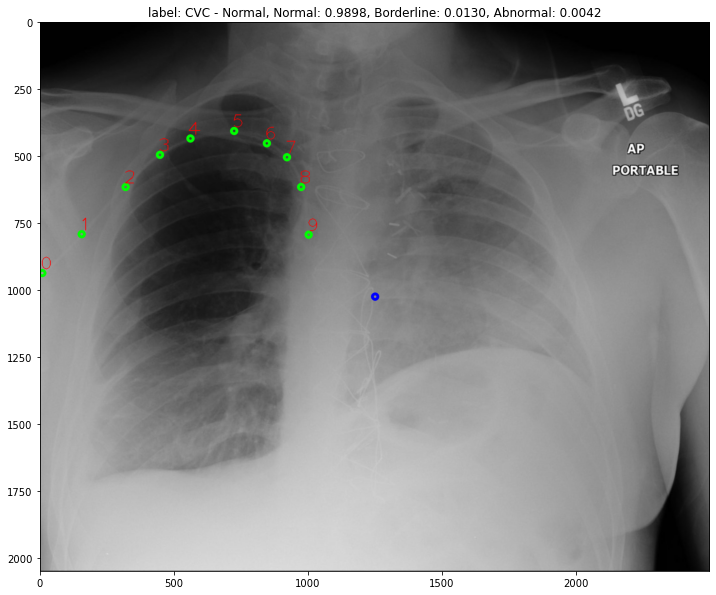

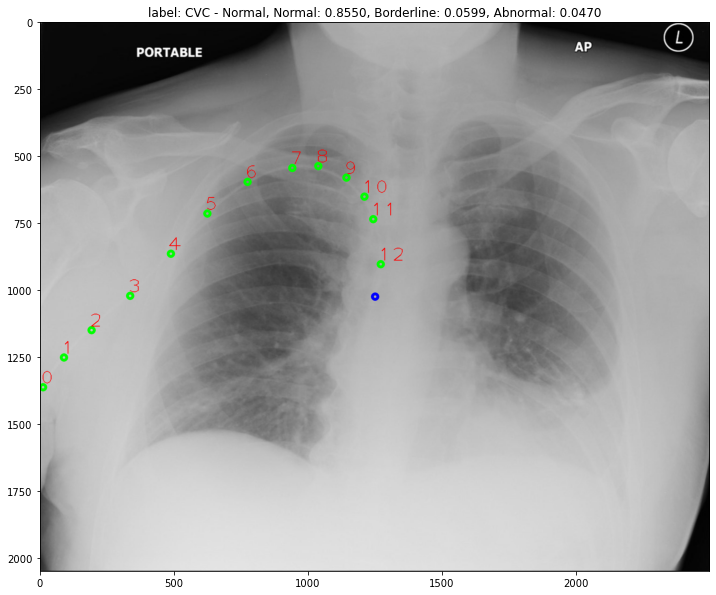

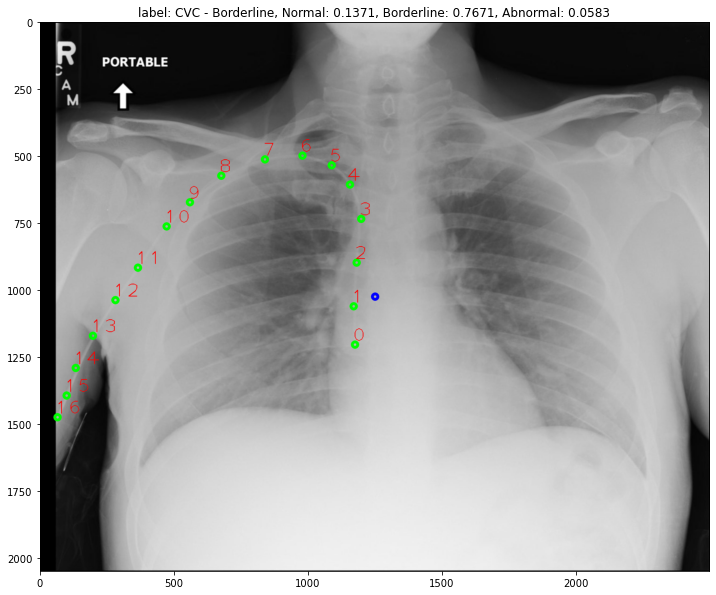

In [56]:
for i in range(10):
    ind = i
    row = df_anot_cvc.iloc[ind]
    plot_xray(row.StudyInstanceUID, row.label, row.data)

In [ ]:
for i in tqdm(range(len(df_anot_cvc))):
    ind = i
    row = df_anot_cvc.iloc[ind]
    patient_id = df[df.StudyInstanceUID == row.StudyInstanceUID].PatientID.values[0]
    save_xray(row.StudyInstanceUID, row.label, row.data, patient_id, i)

 83%|████████▎ | 9608/11629 [2:32:51<37:23,  1.11s/it]  

In [2]:
import os

In [3]:
len(os.listdir('/data/eda_plot/cvc_tube/'))

1951